In [69]:
import matplotlib.pyplot as plt
import time

In [70]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [71]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [72]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


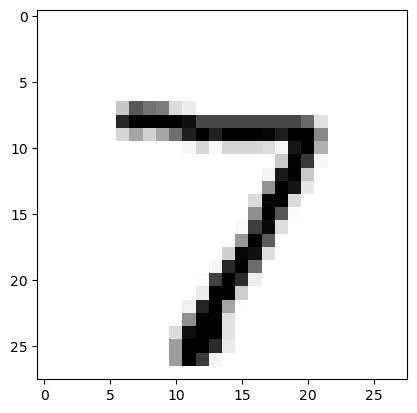

In [73]:
for feature, label in test_dataloader:
    plt.imshow(feature[0][0], cmap='Greys')
    plt.show()
    break

In [112]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# device = 'cpu'
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.conv2 = nn.Conv2d(10, 100, 3)
        self.fc1 = nn.Linear(100 * 5 * 5, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 10)
        self.linear_relu_stack = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            self.conv2,
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            self.fc1,
            nn.ReLU(),
            self.fc2,
            nn.ReLU(),
            self.fc3,
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
        
model = NeuralNetwork().to(device)

Using cuda device


In [102]:
_ = next(iter(train_dataloader))[0]
print(_.shape)
_ = nn.Conv2d(1, 6, 3)(_)
print(_.shape)
_ = nn.ReLU()(_)
print(_.shape)
_ = nn.MaxPool2d(2, 2)(_)
print(_.shape)
_ = nn.Conv2d(6, 36, 3)(_)
print(_.shape)
_ = nn.ReLU()(_)
print(_.shape)
_ = nn.MaxPool2d(2, 2)(_)
print(_.shape)
_ = nn.Flatten()(_)
print(_.shape)
_ = nn.Linear(36 * 5 * 5, 300)(_)
print(_.shape)
_ = nn.ReLU()(_)
print(_.shape)
_ = nn.Linear(300, 100)(_)
print(_.shape)
_ = nn.ReLU()(_)
print(_.shape)
_ = nn.Linear(100, 10)(_)
print(_.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 6, 26, 26])
torch.Size([64, 6, 26, 26])
torch.Size([64, 6, 13, 13])
torch.Size([64, 36, 11, 11])
torch.Size([64, 36, 11, 11])
torch.Size([64, 36, 5, 5])
torch.Size([64, 900])
torch.Size([64, 300])
torch.Size([64, 300])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 10])


In [113]:
try:
    model = NeuralNetwork().to(device)
    model.load_state_dict(torch.load("model.CNN_mnist.pth"))
    print('loaded model')
except:
    model = NeuralNetwork().to(device)
    print("Initialized new model")

Initialized new model


In [114]:
total_params = 0
for params in model.parameters():
    total_params += params.nelement()
print('Total parameters:', total_params)

Total parameters: 1310810


In [115]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [93]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [94]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [116]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.313822  [    0/60000]
loss: 2.294544  [ 6400/60000]
loss: 2.278738  [12800/60000]
loss: 2.243094  [19200/60000]
loss: 2.201306  [25600/60000]
loss: 2.041583  [32000/60000]
loss: 1.394995  [38400/60000]
loss: 1.113400  [44800/60000]
loss: 0.718748  [51200/60000]
loss: 0.577273  [57600/60000]
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.499397 

Epoch 2
-------------------------------
loss: 0.534872  [    0/60000]
loss: 0.375692  [ 6400/60000]
loss: 0.315100  [12800/60000]
loss: 0.359868  [19200/60000]
loss: 0.292854  [25600/60000]
loss: 0.358585  [32000/60000]
loss: 0.245492  [38400/60000]
loss: 0.429552  [44800/60000]
loss: 0.386233  [51200/60000]
loss: 0.315140  [57600/60000]
Test Error: 
 Accuracy: 91.8%, Avg loss: 0.256253 

Epoch 3
-------------------------------
loss: 0.281936  [    0/60000]
loss: 0.248067  [ 6400/60000]
loss: 0.159322  [12800/60000]
loss: 0.283224  [19200/60000]
loss: 0.178897  [25600/60000]
loss: 0.226372  [32000/600

In [21]:
torch.save(model.state_dict(), "model.CNN_mnist.pth")
print("Saved PyTorch Model State to model.CNN_mnist.pth")

Saved PyTorch Model State to CNN_mnist.pt


In [18]:
classes = test_data.classes

model.eval()
x, y = next(iter(test_dataloader))
with torch.no_grad():
    pred = model(x.to(device))
    predicted, actual = classes[pred[0].argmax(0)], classes[y[0]]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "7 - seven", Actual: "7 - seven"


Predicted: "9 - nine", Actual: "4 - four"


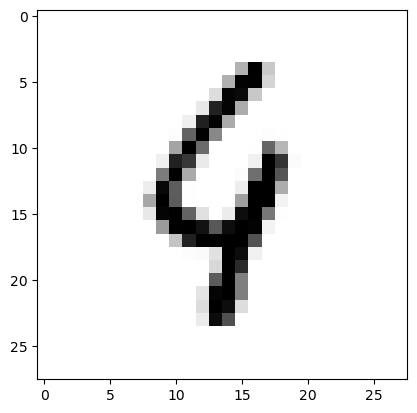

Predicted: "2 - two", Actual: "4 - four"


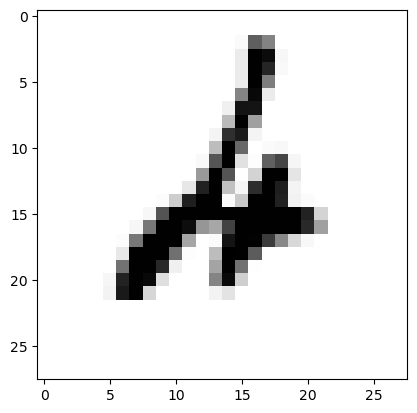

Predicted: "0 - zero", Actual: "6 - six"


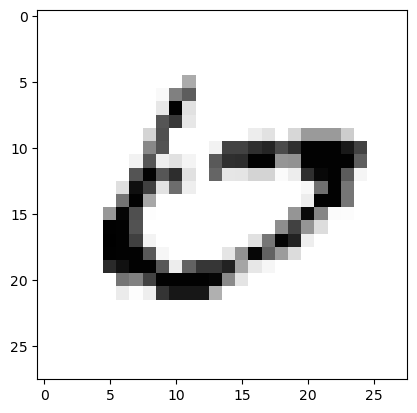

Predicted: "5 - five", Actual: "3 - three"


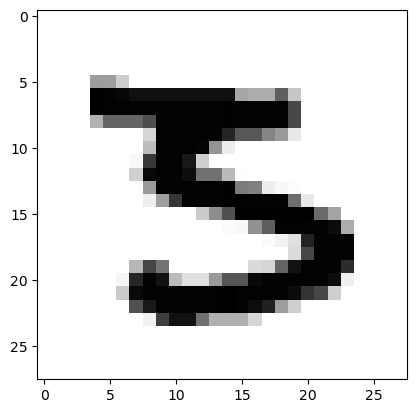

Predicted: "2 - two", Actual: "8 - eight"


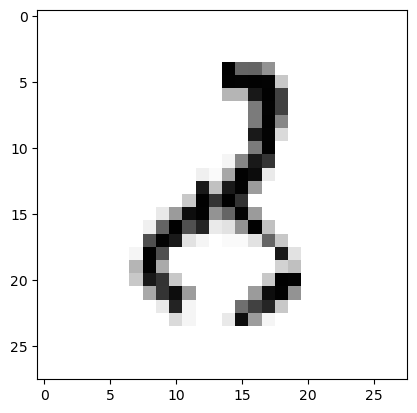

Predicted: "6 - six", Actual: "2 - two"


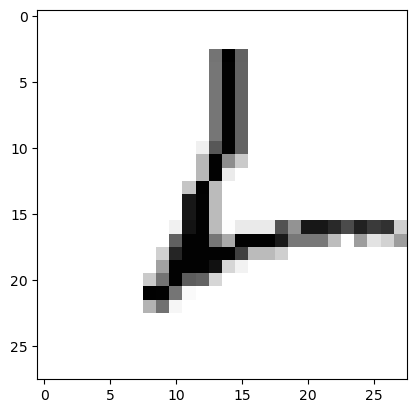

Predicted: "1 - one", Actual: "2 - two"


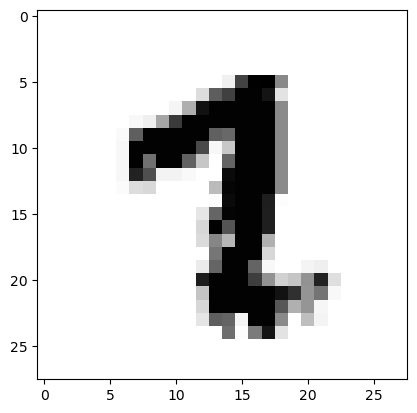

Predicted: "9 - nine", Actual: "8 - eight"


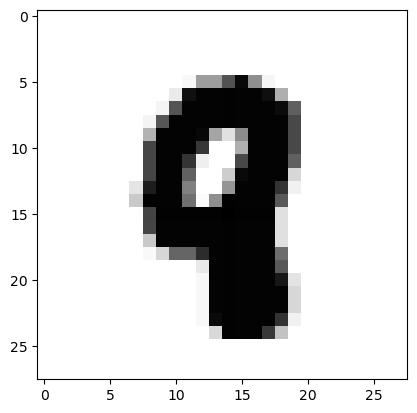

Predicted: "5 - five", Actual: "6 - six"


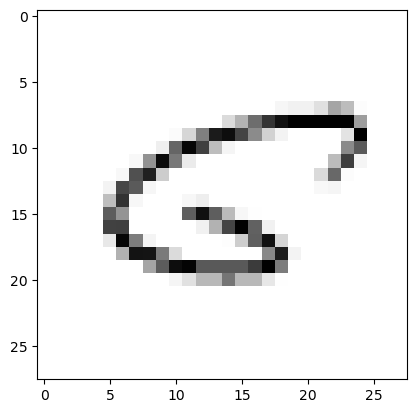

Predicted: "1 - one", Actual: "7 - seven"


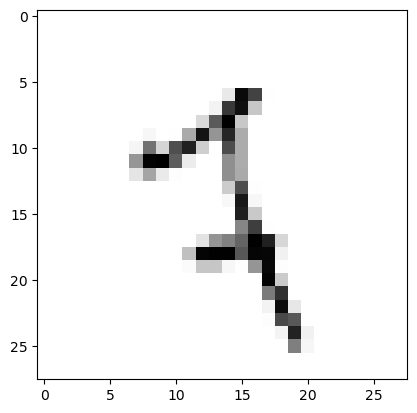

Predicted: "6 - six", Actual: "4 - four"


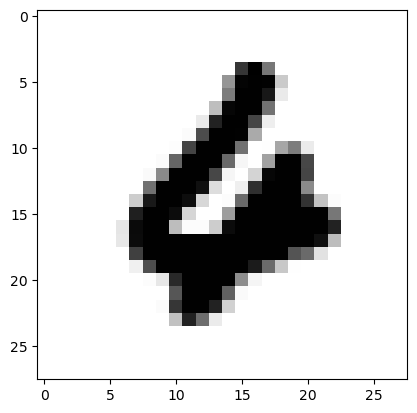

In [119]:
model.eval()
num_show = 10
with torch.no_grad():
    for x, y in test_dataloader:
        pred = model(x.to(device))
        for i in range(len(pred)):
            predicted, actual = classes[pred[i].argmax(0)], classes[y[i]]
            if predicted != actual:
                print(f'Predicted: "{predicted}", Actual: "{actual}"')
                plt.imshow(x[i][0], cmap='Greys')
                plt.show()
                num_show -= 1
            if num_show < 0:
                break
        if num_show < 0:
            break

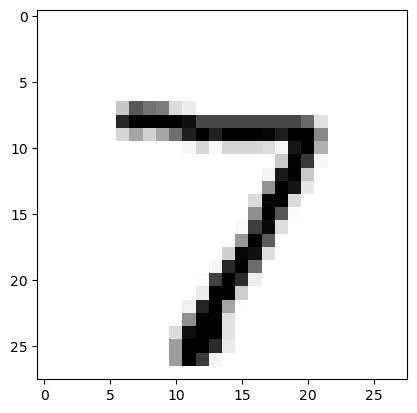

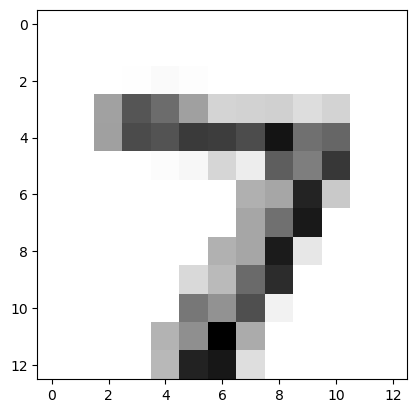

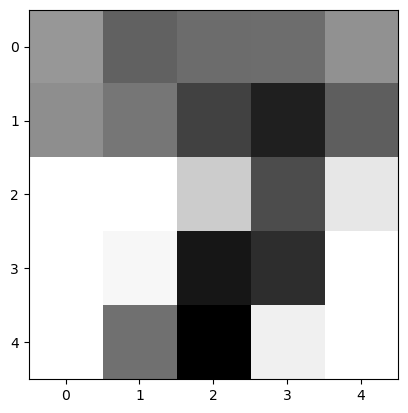

In [130]:
def show(img):
    plt.imshow(img.to('cpu').detach().numpy(), cmap='Greys')
    plt.show()

idx = 6
for feature, label in test_dataloader:
    feature = feature.to(device)
    show(feature[0][0])
    feature = nn.MaxPool2d(2,2)(nn.ReLU()(model.conv1(feature)))
    show(feature[0][idx])
    feature = nn.MaxPool2d(2,2)(nn.ReLU()(model.conv2(feature)))
    show(feature[0][idx])
    break
